In [1]:
import sys
sys.path.append("../../src/earthtext")

import rasterio
import xarray as xr
import os
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from osm import osm
from collections import OrderedDict
import pandas as pd
get_region_hash = osm.get_region_hash

In [2]:
imgs_folder    = "/opt/data/clay-california-worldcover-rgbnir-vvvh-chips/chips"
osmobjs_folder = "/opt/data/california-worldcover-chips/osm"
master_index   = "/opt/data/california-worldcover-chips.fgb"

In [112]:
class ImageOSMData:

    def __init__(self, imgs_folder, osmobjs_folder, master_index):
        self.imgs_folder = imgs_folder
        self.osmobjs_folder = osmobjs_folder
        self.master_index = master_index

    def init_index(self):
        self.m = gpd.read_file(master_index)
        self.m.index = [get_region_hash(gi) for gi in self.m.geometry.values]
        return self

    def sample_chip(self):
        chip_id = self.m.index[np.random.randint(len(self.m))]
        return ImageOSMChip(self, chip_id)
    
class ImageOSMChip:

    def __init__(self, iosmdata, chip_id):

        self.iosmdata = iosmdata
        self.chip_id = chip_id
        
    def read_osm(self, min_area=0):
        """
        reads the osm objects for this chip id, cleaning up key/values
        """
        if not self.chip_id in self.iosmdata.m.index:
            raise ValueError(f"chip {self.chip_id} not indexed")
            
        try:
            z = gpd.read_parquet(f"{self.iosmdata.osmobjs_folder}/{self.chip_id}.parquet")
            z['tags'] = [eval(i) if isinstance(i, str) else i for i in z.tags]
            z['tags'] = [osm.clean_tags(t) for t in z.tags]
            z = z[[len(t)>0 for t in z['tags']]]
            z = z[z['area']>=min_area]
    
            if len(z)==0:
                self.osm = None
            else:
                self.osm = z.copy()
        except:
            self.osm = None

        return self

    def read_img(self):
        if not self.chip_id in self.iosmdata.m.index:
            raise ValueError(f"chip {self.chip_id} not indexed")
            
        mi = self.iosmdata.m.loc[self.chip_id]
        fname = f"{self.iosmdata.imgs_folder}/worldcover_california_chip_{mi['col']}_{mi['row']}.tif"
        
        with xr.open_dataarray(fname) as z:
            self.img = z.data.copy()

        return self

    def get_keyvals_count(self):
        """
        counts the occurrences of key/vals in the osm objects of this chip

        returns: a dictionary with the count of each key/val
        """
        r = []
        for _,o in self.osm.iterrows():
            if o.kind=='node':
                continue
            if o.area>0:
                # this is a closed way
                keep_keyvalues = osm_keyvals_closedways
            else:
                # this is an open way
                keep_keyvalues = osm_keyvals_openways
                
            for k,v in o['tags'].items():
                if k in keep_keyvalues and v in keep_keyvalues[k]:
                    r.append(f"{k}={v}")
                    if not k in r:
                        r.append(k)
        return pd.Series(r).value_counts()
    
    def show(self):
        for ax, i in subplots(len(self.img), n_cols=6, usizex=4):
            _x = self.img[i]
            a,b = np.percentile(_x, [1,99])
            plt.imshow(_x, vmin=a, vmax=b)
            plt.colorbar()
            if i==0:
                plt.title(self.chip_id)

    def get_keyvalue_codes(self, keyvaluecodes):
        ## TODO: distinguish open ways from closed ways
        return [i for j in [keyvaluecodes.get_codes(ti) for ti in self.osm.tags] for i in j]
    
class OSMKeyValueCodes:

    def __init__(self, kind):

        if not kind in ['openways', 'closedways']:
            raise ValueError(f"invalid kind '{kind}', kind must be 'openways' or 'closedways'")

        if kind=='closedways':
        
            osm_keyvals = {}
            osm_keyvals['landuse']  = ['residential', 'grass', 'farmland', 'meadow', 'commercial', 'orchard', 'vineyard', 'industrial', 
                                                   'retail', 'farmyard', 'forest', 'military', 'farm', 'cemetery', 'brownfield', 'quarry', 'greenfield']
            osm_keyvals['natural']  = ['water', 'wood', 'scrub', 'sand', 'grassland', 'wetland', 'bare_rock', 'coastline', 'heath', 'valley', 
                                                  'desert', 'cliff', 'scree', 'beach', 'mountain_range', 'mud', 'bay']
            osm_keyvals['leisure']  = ['pitch', 'park', 'garden', 'nature_reserve', 'sports_centre', 'golf_course', 'track', 'schoolyard', 'stadium']
            osm_keyvals['water']    = ['pond', 'reservoir', 'lake', 'river', 'canal', 'wastewater', 'stream', 'ditch', 'stream;river']
            osm_keyvals['sport']    = ['baseball', 'soccer', 'american_football', 'running', 'equestrian', 'athletics', 'motor', 'multi']
            osm_keyvals['building'] = ['house', 'residential', 'apartments', 'industrial', 'school', 'warehouse']
            osm_keyvals['surface']  = ['asphalt', 'concrete', 'paved', 'gravel', 'sand', 'grass']
            osm_keyvals['crop']     = ['grape', 'field_cropland', 'WINE GRAPES', 'native_pasture']
            osm_keyvals['power']    = ['generator', 'substation', 'plant']
            osm_keyvals['parking']  = ['surface', 'multi-storey']
            osm_keyvals['highway']  = ['track']
            osm_keyvals['waterway'] = ['dam']
            osm_keyvals['amenity']  = ['parking']
            
        elif kind == 'openways':
            osm_keyvals = {}
            osm_keyvals['highway']  = ['motorway', 'residential', 'track']
            osm_keyvals['waterway'] = ['stream', 'river']

        # maps to remove duplicated and standardize
        self.raw_osm_keyvals = osm_keyvals
        self.osm_keyvals = {k: list(set([self.map_keyval(k,vi)[1] for vi in v])) for k,v in self.raw_osm_keyvals.items()}
        
        # assign a seq number to each keyval pair, including each single key (with no val)
        self.osm_keyvals_strings = [f"{k}={v}" for k in osm_keyvals.keys() for v in sorted(self.osm_keyvals[k]) ] + list(self.osm_keyvals.keys())
        
        # assigned a code to each keyvalue pair
        self.keyvals_codes = {k:i for i,k in enumerate(sorted(self.osm_keyvals_strings))}

    def map_keyval(self, key, val):
        """
        maps a key, val pair to remove duplicates, standardize, etc.
        
        keyvals: a dict with osm key values

        returns: a (key,value) tuple with the mapped keyval, or (None, None) 
        """
        k,v = key,val
        
        if k=='crop' and v=='WINE GRAPES':
            k, v = 'crop', 'grape'
        if k=='water' and v=='stream;river':
            k, v = 'water', 'stream'

        return k, v
        
    def get_codes(self, keyvals):
        """
        returns a list of codes, one for each key/value pair in the input dictionary
        including a code for each single key (with no value).
        it returns only the codes for the key/value pairs considered in the constructor
        after mapping to stardardize them
        
        keyvals: a dictionary
        """

        keyvals = {kk:vv for kk,vv in [self.map_keyval(k,v) for k,v in keyvals.items()]}
        keyvals = {k:v for k,v in keyvals.items() if k in self.osm_keyvals.keys() and v in self.osm_keyvals[k]}
        r = []
        for k in keyvals.keys():
            if k in self.keyvals_codes.keys():
                r.append(self.keyvals_codes[k])
                     
        for k,v in keyvals.items():
            k,v = self.map_keyval(k,v)
            kvstring = f'{k}={v}'
            if kvstring in self.keyvals_codes.keys():
                code  = self.keyvals_codes[kvstring]
                r.append(code)
        return r  

kvopen   = OSMKeyValueCodes(kind='openways')
kvclosed = OSMKeyValueCodes(kind='closedways')

In [113]:
kvopen.keyvals_codes

{'highway': 0,
 'highway=motorway': 1,
 'highway=residential': 2,
 'highway=track': 3,
 'waterway': 4,
 'waterway=river': 5,
 'waterway=stream': 6}

In [114]:
iosdata = ImageOSMData(imgs_folder=imgs_folder, osmobjs_folder=osmobjs_folder, master_index=master_index).init_index()

In [243]:
    def sample_chip(self):
        chip_id = self.m.index[np.random.randint(len(self.m))]
        return ImageOSMChip(self, chip_id)


In [300]:
c = sample_chip(iosdata).read_img().read_osm()

In [301]:
c.osm

,tags,geometry,kind,length,area,stags,chip_id
90862053,{'highway': 'stop'},POINT (-121.09680 38.18621),node,0.000000,0.000000,direction: forward\n<br>\nhighway: stop,1aa639a11f307
2422034994,{'landuse': 'orchard'},POINT (-121.11000 38.18161),node,0.000000,0.000000,landuse: orchard,1aa639a11f307
2422036007,{'shop': 'convenience'},POINT (-121.09961 38.18576),node,0.000000,0.000000,shop: convenience,1aa639a11f307
2983913113,{'landuse': 'vineyard'},POINT (-121.10079 38.18408),node,0.000000,0.000000,landuse: vineyard,1aa639a11f307
352,"{'highway': 'service', 'service': 'driveway'}","LINESTRING (-121.10081 38.18456, -121.10084 38...",way,440.609952,0.000000,highway: service\n<br>\nservice: driveway,1aa639a11f307
733,{'highway': 'residential'},"LINESTRING (-121.11733 38.19859, -121.11592 38...",way,614.153896,0.000000,highway: residential,1aa639a11f307
1392,{'highway': 'residential'},"LINESTRING (-121.09707 38.18133, -121.09702 38...",way,553.492675,0.000000,highway: residential,1aa639a11f307
1463,"{'boat': 'no', 'waterway': 'river'}","LINESTRING (-121.09615 38.20267, -121.09692 38...",way,2674.980819,0.000000,boat: no\n<br>\nwaterway: river,1aa639a11f307
1572,{'highway': 'track'},"LINESTRING (-121.09600 38.20163, -121.09601 38...",way,154.304035,0.000000,highway: track\n<br>\ntracktype: grade3,1aa639a11f307
1573,{'highway': 'track'},"LINESTRING (-121.09744 38.20086, -121.09644 38...",way,663.707797,0.000000,highway: track\n<br>\ntracktype: grade3,1aa639a11f307


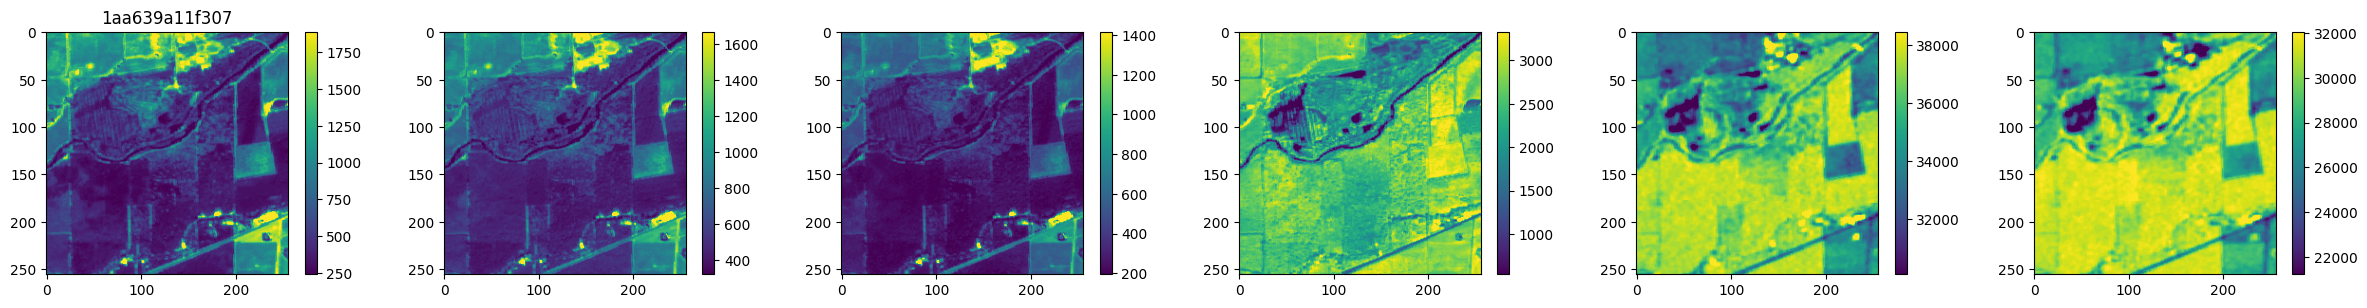

In [302]:
c.show()

In [303]:
self = c
tags_openways   = [o.tags for _,o in self.osm.iterrows() if o.kind=='way' and o.area==0]
tags_closedways = [o.tags for _,o in self.osm.iterrows() if o.kind=='way' and o.area>0]

len(tags_closedways), len(tags_openways)


(8, 26)

In [304]:
open_codes = [i for t in tags_openways for i in kvopen.get_codes(t)]
closed_codes = [i for t in tags_closedways for i in kvclosed.get_codes(t)]

In [305]:
print(closed_codes)
print (open_codes)

[43, 58, 15, 30, 15, 30, 15, 29, 15, 26, 15, 26, 15, 26, 43, 56]
[0, 2, 0, 2, 4, 5, 0, 3, 0, 3, 4, 6, 0, 3, 0, 3, 0, 3]


In [306]:
{k:v for k,v in kvclosed.keyvals_codes.items() if v in closed_codes}

{'landuse': 15,
 'landuse=meadow': 26,
 'landuse=quarry': 29,
 'landuse=residential': 30,
 'natural': 43,
 'natural=scrub': 56,
 'natural=water': 58}

In [307]:
{k:v for k,v in kvopen.keyvals_codes.items() if v in open_codes}

{'highway': 0,
 'highway=residential': 2,
 'highway=track': 3,
 'waterway': 4,
 'waterway=river': 5,
 'waterway=stream': 6}